Kernel features :

- [Data Wrangling / Data Preparation](#data-wrangling)
- [RFM Segmentation](#rfm-segmentation)
- [Cohort Analysis](#cohort-analysis)

&nbsp;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

Data diambil dari [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data) yang merupakan public dataset dari salah satu ecommerce retailer di UK

In [2]:
df = pd.read_csv('D:\Backup Faiszal\D\Faiz\Data\Kaggle\ecommerce-data\data.csv', encoding = "ISO-8859-1")

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


&nbsp;

<a name="data-wrangling"></a>

## Data Wrangling

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #ubah format InvoiceDate menjadi datetime

In [5]:
print("Informasi dari dataset :")
print("Jumlah Row \t\t:", df.shape[0]) #check jumlah total rows pada data
print("Jumlah Column \t\t:", df.shape[1]) #check jumlah total coloumns pada data
print("Date range from \t:", df.InvoiceDate.min(), " to ", df.InvoiceDate.max()) #check range waktu pada data
print("#Jumlah Transaksi \t:", df.InvoiceNo.nunique()) #check jumlah transaksi
print("#Unique Customer \t:", df.CustomerID.nunique()) #check jumlah unique customer
print("Range Quantity \t\t:", df.Quantity.min(), " to ", df.Quantity.max()) #check range Quantity pada data
print("Range UnitPrice \t:", df.UnitPrice.min(), " to ", df.UnitPrice.max()) #check range UnitPrice pada data

Informasi dari dataset :
Jumlah Row 		: 541909
Jumlah Column 		: 8
Date range from 	: 2010-12-01 08:26:00  to  2011-12-09 12:50:00
#Jumlah Transaksi 	: 25900
#Unique Customer 	: 4372
Range Quantity 		: -80995  to  80995
Range UnitPrice 	: -11062.06  to  38970.0


In [6]:
print(df.isnull().sum().sort_values(ascending=False))

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64


- Beberapa data memiliki Quantity dan UnitPrice yang bernilai Negatif
- Beberapa data memiliki CustomerID dan Description null / kosong

kita akan drop data tersebut

In [7]:
df_new = df.dropna() ## remove null
df_new = df_new[df_new.Quantity > 0] ## remove negative value pada kolom Quantity
df_new = df_new[df_new.UnitPrice > 0] ## remove negative value pada kolom UnitPrice

In [8]:
print(df_new.isnull().sum().sort_values(ascending=False))

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64


In [9]:
df_new['Revenue'] = df_new['Quantity'] * df_new['UnitPrice'] ## penambahan kolom Revenue (Qty * UnitPrice)
df_new['CustomerID'] = df_new['CustomerID'].astype('int64') #ubah format CustomerID

&nbsp;

<a name="rfm-segmentation"></a>

## RFM Segmentation

RFM Segmentation adalah segmentasi customer berdasarkan scoring R,F,dan M (Recency : Lamanya hari semenjak transaksi terakhir, Frequency : Banyaknya transaksi, Monetary : Total Revenue).

Karena transaksi terakhir pada data adalah pada tanggal 09 Desember 2011, maka kita akan menggunakan tanggal 10 Desember 2011 untuk menghitung recency

In [10]:
import datetime as dt
NOW = dt.datetime(2011,12,10)

In [11]:
rfmTable = df_new.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Revenue': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Revenue': 'monetary'}, inplace=True)

In [12]:
rfmTable.head()

,recency,frequency,monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40


### Interpretation :

Customer dengan ID 12346 mempunyai **frequency**: 1 (1 kali transaksi), **recency**: 325 (325 hari dari transaksi terakhir), dan **monetary** 77183.60 (Grand total transaksi)
 

Customer dengan email 12347 mempunyai **frequency**: 182 (182 kali transaksi complete), **recency**: 2 (2 hari dari transaksi terakhir), dan **monetary** 4310.00(Grand total transaksi)
 


Cara termudah untuk membuat segment adalah dengan metode quartile. Dengan metode tersebut akan didapat 4 segment yang mudah untuk dimengerti

<img src="https://www.mathsisfun.com/data/images/quartiles-c.gif" />

In [13]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

In [14]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [15]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346,325,1,77183.60,1,1,4
12347,2,182,4310.00,4,4,4
12348,75,31,1797.24,2,2,4
12349,18,73,1757.55,3,3,4
12350,310,17,334.40,1,1,2


In [16]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)+segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346,325,1,77183.60,1,1,4,114
12347,2,182,4310.00,4,4,4,444
12348,75,31,1797.24,2,2,4,224
12349,18,73,1757.55,3,3,4,334
12350,310,17,334.40,1,1,2,112


RFM score: 444 adalah score terbaik karena memiliki **recency** yang rendah (masih aktif), **frequency** tinggi (sering melakukan transaksi) dan **monetary** yang tinggi

&nbsp;

### Top 5 Customer based on RFMScore

In [17]:
segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('monetary', ascending=False).head()


,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
14646,1,2076,280206.02,4,4,4,444
18102,0,431,259657.30,4,4,4,444
17450,8,337,194550.79,4,4,4,444
14911,1,5675,143825.06,4,4,4,444
14156,9,1400,117379.63,4,4,4,444


Mari kita lihat lebih detail transaksi CustomerID 14646 

In [18]:
top_customer = df_new[df_new['CustomerID'] == 14646]
top_customer.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646,Netherlands,3.48
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646,Netherlands,3.48
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646,Netherlands,9.90
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646,Netherlands,1.95
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-20 10:09:00,0.85,14646,Netherlands,1.70
37957,539491,20751,FUNKY WASHING UP GLOVES ASSORTED,1,2010-12-20 10:09:00,2.10,14646,Netherlands,2.10
37958,539491,21246,RED RETROSPOT BIG BOWL,2,2010-12-20 10:09:00,4.95,14646,Netherlands,9.90
37959,539491,22960,JAM MAKING SET WITH JARS,1,2010-12-20 10:09:00,4.25,14646,Netherlands,4.25
37960,539491,22355,CHARLOTTE BAG SUKI DESIGN,2,2010-12-20 10:09:00,0.85,14646,Netherlands,1.70
37961,539491,21123,SET/10 IVORY POLKADOT PARTY CANDLES,2,2010-12-20 10:09:00,1.25,14646,Netherlands,2.50


&nbsp;

<a name="cohort-analysis"></a>

## Cohort Analysis

In [19]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [23]:
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_new['InvoiceMonth'] = df_new['InvoiceDate'].apply(get_month)
grouping = df_new.groupby('CustomerID')['InvoiceMonth']
df_new['CohortMonth'] = grouping.transform('min')

In [24]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01


In [25]:
## function untuk extract integer value dari data
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [26]:
invoice_year, invoice_month, _ = get_date_int(df_new, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df_new, 'CohortMonth')

In [27]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [28]:
df_new['CohortIndex'] = years_diff * 12 + months_diff + 1

In [31]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [32]:
## grouping customer berdasarkan masing masing cohort
grouping = df_new.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [34]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


&nbsp;

### Intepretation :

<img src="https://i.imgur.com/FQn5sDf.png" />

CohortMonth 2010-12 (Cohort Desember 2010) memiliki 885 Unique customer yang melakukan transaksi pada bulan tersebut (CohortIndex 1), <br>
324 customer kembali melakukan transaksi dibulan berikutnya (CohortIndex 2), <br>
286 customer kembali lagi dibulan selanjutnya (CohortIndex 3), dan seterusnya.

### Retention Rate

In [35]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(2) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,37.0,32.0,38.0,36.0,40.0,36.0,35.0,35.0,40.0,37.0,50.0,27.0
2011-01-01,100.0,22.0,27.0,23.0,32.0,29.0,25.0,24.0,30.0,33.0,36.0,12.0,NaN
2011-02-01,100.0,19.0,19.0,28.0,27.0,25.0,25.0,28.0,25.0,31.0,7.0,NaN,NaN
2011-03-01,100.0,15.0,25.0,20.0,22.0,17.0,27.0,23.0,28.0,9.0,NaN,NaN,NaN
2011-04-01,100.0,21.0,20.0,21.0,20.0,23.0,22.0,26.0,7.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.0,17.0,21.0,23.0,26.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.0,16.0,26.0,23.0,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.0,21.0,22.0,27.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.0,25.0,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


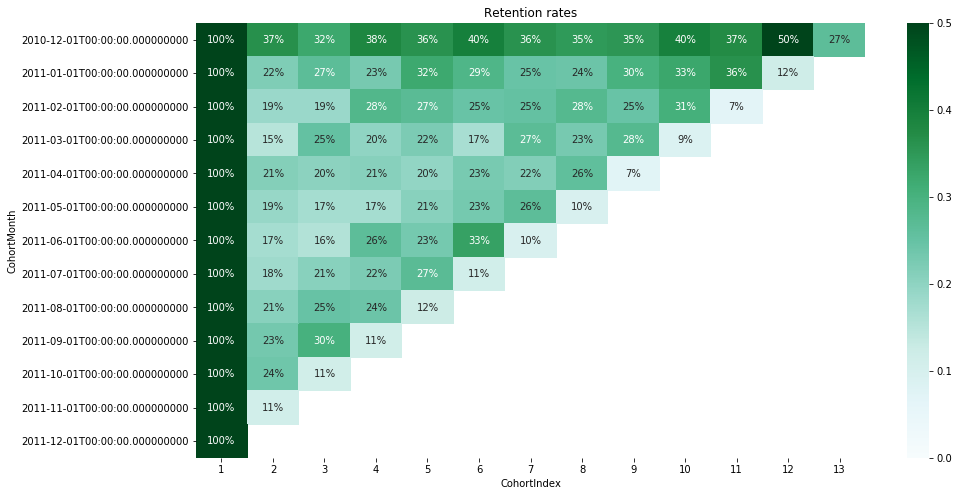

In [37]:
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
annot = True,
fmt = '.0%',
vmin = 0.0,
vmax = 0.5,
cmap = 'BuGn')
plt.show()

Retention Rate seringkali diabaikan, tapi sebenarnya sangat penting. Karena biaya customer acquisition sangat mahal kita perlu melakukan apapun untuk meyakinkan client untuk kembali lagi setelah pembelian pertama mereka. <p>

Jika Retention Rate Anda rendah Anda akan mengeluarkan budget untuk acquisition channel agar semakin banyak customer yang datang. <p>

Dari Analisa Cohort kita bisa melihat retention rate atau berapa persen customer yang kembali di bulan - bulan berikutnya setelah pembelian pertama